# Lithology prediction with Python

Recently, machine learning has increased in popularity in many industries. In the Oil and Gas industry the implementation of data driven methodologies has increased, specially in the Upstream sector, where machine learning models are used to leverage the vast amount of data available for geoscientist although in some circumstances this data is relatively small when compared to the task that must be completed.

The main goal of this project is to build a machine learning model using popular python libraries and datasets available on the [FORCE 2020 ML competition](https://github.com/bolgebrygg/Force-2020-Machine-Learning-competition) Github repository. The datasets available on the official Github repository are the training data, and test data, with the earlier having 29 columns and over one million observations, and the latter with just as many columns but with only around 122,000 examples. The final model will be build gradually, starting from a simple model trained on an imbalanced dataset with only the well logs and the depth as features, and increasing in complexity as we perform different data imputation techniques on the training data to improve its quality and boost learning, and tune the hyperparameters to improve the model performance.

# Importing libraries

First, we will import commonly available python libraries. These libraries contain useful classes and functions that allow us to write a few lines of code in order to perform task that otherwise would require a lot of custom written code. Following is a short description of each library:

- **Pandas**: A Python library built over numpy, useful for data analysis tasks. Stores functions that allow us to generate statistics for our data, manipulate the data, and visualize it through wrappers over other libraries such as Matplotllib.
- **Numpy**: A scientific Python library that allows the generation of matrices and vectors, and supports complex operations between such data structures. Numpy also allows for vectorized operations which means that multiple operations are done on a single cpu cycle.
- **Matplotlib**: Maybe Python's most commonly used data visualization library. It is used for visualizing data by generating plots. 
- **Seaborn**: A data visualization library that lets us further customize plots and generate more specific plots like violin and linear regression plots, as well as facilitating the generation of conditional plots and pairplots.
- **Scikit-learn**: A popular machine learning library with tools for data processing, building data pipelines, and training, building and evaluating machine learning models.
- **Boruta**: An open source Python library used for feature selection. Commonly used by kagglers on competitions.
- **Umap-learn**: An open source library for Uniform Manifold Approximation and Projection a method for dimensionality reduction commonly preferred over PCA (Principal Component Analysis) and autoencoders because its results are easier to visualize on plots than the results of PCA and it is faster than autoencoders.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, OneClassSVM
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from boruta import BorutaPy
import umap
%matplotlib inline

For this project we will also use some custom functions, which are commonly stored in python scripts. We can generate folders that store scripts for functions of a similar topic and add such folders to our current python path by using the built-in `sys` python library. This allows us to import this custom functions as if we were importing built-in or commonly available open source libraries.

In [2]:
import sys
sys.path.append('formation_evaluation')

In [3]:
import well_log_display

It should be noted that the `well_log_display` function, as well as other functions in the "formation_evaluation" folder, was originally coded by Yohanes Nuwara and is available on his own Github repository.

# Loading the data

We will use the pandas library `pd.read_csv()` function to read our dataset, the default separator for csv files is the "," character, however our file uses the ";" character to separate values.

In [4]:
logs_data = pd.read_csv('datasets1/log_train.csv', sep=';')
logs_data.head(10)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
0,15/9-13,494.528,437641.96875,6470972.5,-469.501831,NORDLAND GP.,NaN,19.480835,NaN,1.611410,...,34.636410,NaN,NaN,-0.574928,NaN,NaN,NaN,NaN,65000,1.0
1,15/9-13,494.680,437641.96875,6470972.5,-469.653809,NORDLAND GP.,NaN,19.468800,NaN,1.618070,...,34.636410,NaN,NaN,-0.570188,NaN,NaN,NaN,NaN,65000,1.0
2,15/9-13,494.832,437641.96875,6470972.5,-469.805786,NORDLAND GP.,NaN,19.468800,NaN,1.626459,...,34.779556,NaN,NaN,-0.574245,NaN,NaN,NaN,NaN,65000,1.0
3,15/9-13,494.984,437641.96875,6470972.5,-469.957794,NORDLAND GP.,NaN,19.459282,NaN,1.621594,...,39.965164,NaN,NaN,-0.586315,NaN,NaN,NaN,NaN,65000,1.0
4,15/9-13,495.136,437641.96875,6470972.5,-470.109772,NORDLAND GP.,NaN,19.453100,NaN,1.602679,...,57.483765,NaN,NaN,-0.597914,NaN,NaN,NaN,NaN,65000,1.0
5,15/9-13,495.288,437641.96875,6470972.5,-470.261780,NORDLAND GP.,NaN,19.453100,NaN,1.585567,...,75.281410,NaN,NaN,-0.601600,NaN,NaN,NaN,NaN,65000,1.0
6,15/9-13,495.440,437641.96875,6470972.5,-470.413788,NORDLAND GP.,NaN,19.462496,NaN,1.576569,...,76.199951,NaN,NaN,-0.598369,NaN,NaN,NaN,NaN,65000,1.0
7,15/9-13,495.592,437641.96875,6470972.5,-470.565796,NORDLAND GP.,NaN,19.468800,NaN,1.587011,...,76.199951,NaN,NaN,-0.602039,NaN,NaN,NaN,NaN,65000,1.0
8,15/9-13,495.744,437641.96875,6470972.5,-470.717773,NORDLAND GP.,NaN,19.468800,NaN,1.613674,...,75.898796,NaN,NaN,-0.614364,NaN,NaN,NaN,NaN,65000,1.0
9,15/9-13,495.896,437641.96875,6470972.5,-470.869782,NORDLAND GP.,NaN,19.468800,NaN,1.634622,...,68.121262,NaN,NaN,-0.621813,NaN,NaN,NaN,NaN,65000,1.0


Sometimes our dataset is too big to be completely displayed. We can use the `pd.set_option()` function to specify the maximum number of rows or columns to be displayed.

In [5]:
pd.set_option('display.max_columns', None)
logs_data.head(10)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,RDEP,RHOB,GR,SGR,NPHI,PEF,DTC,SP,BS,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
0,15/9-13,494.528,437641.96875,6470972.5,-469.501831,NORDLAND GP.,NaN,19.480835,NaN,1.611410,1.798681,1.884186,80.200851,NaN,NaN,20.915468,161.131180,24.612379,NaN,34.636410,NaN,NaN,-0.574928,NaN,NaN,NaN,NaN,65000,1.0
1,15/9-13,494.680,437641.96875,6470972.5,-469.653809,NORDLAND GP.,NaN,19.468800,NaN,1.618070,1.795641,1.889794,79.262886,NaN,NaN,19.383013,160.603470,23.895531,NaN,34.636410,NaN,NaN,-0.570188,NaN,NaN,NaN,NaN,65000,1.0
2,15/9-13,494.832,437641.96875,6470972.5,-469.805786,NORDLAND GP.,NaN,19.468800,NaN,1.626459,1.800733,1.896523,74.821999,NaN,NaN,22.591518,160.173615,23.916357,NaN,34.779556,NaN,NaN,-0.574245,NaN,NaN,NaN,NaN,65000,1.0
3,15/9-13,494.984,437641.96875,6470972.5,-469.957794,NORDLAND GP.,NaN,19.459282,NaN,1.621594,1.801517,1.891913,72.878922,NaN,NaN,32.191910,160.149429,23.793688,NaN,39.965164,NaN,NaN,-0.586315,NaN,NaN,NaN,NaN,65000,1.0
4,15/9-13,495.136,437641.96875,6470972.5,-470.109772,NORDLAND GP.,NaN,19.453100,NaN,1.602679,1.795299,1.880034,71.729141,NaN,NaN,38.495632,160.128342,24.104078,NaN,57.483765,NaN,NaN,-0.597914,NaN,NaN,NaN,NaN,65000,1.0
5,15/9-13,495.288,437641.96875,6470972.5,-470.261780,NORDLAND GP.,NaN,19.453100,NaN,1.585567,1.804719,1.879687,72.014420,NaN,NaN,43.657482,160.149292,23.931278,NaN,75.281410,NaN,NaN,-0.601600,NaN,NaN,NaN,NaN,65000,1.0
6,15/9-13,495.440,437641.96875,6470972.5,-470.413788,NORDLAND GP.,NaN,19.462496,NaN,1.576569,1.805498,1.878731,72.588089,NaN,NaN,42.236221,161.250381,23.381790,NaN,76.199951,NaN,NaN,-0.598369,NaN,NaN,NaN,NaN,65000,1.0
7,15/9-13,495.592,437641.96875,6470972.5,-470.565796,NORDLAND GP.,NaN,19.468800,NaN,1.587011,1.808367,1.867837,71.283051,NaN,NaN,39.933563,162.214416,23.632166,NaN,76.199951,NaN,NaN,-0.602039,NaN,NaN,NaN,NaN,65000,1.0
8,15/9-13,495.744,437641.96875,6470972.5,-470.717773,NORDLAND GP.,NaN,19.468800,NaN,1.613674,1.815813,1.847233,69.721436,NaN,NaN,39.163223,161.575104,22.163542,NaN,75.898796,NaN,NaN,-0.614364,NaN,NaN,NaN,NaN,65000,1.0
9,15/9-13,495.896,437641.96875,6470972.5,-470.869782,NORDLAND GP.,NaN,19.468800,NaN,1.634622,1.813916,1.836309,66.677727,NaN,NaN,37.802933,160.583359,23.659925,NaN,68.121262,NaN,NaN,-0.621813,NaN,NaN,NaN,NaN,65000,1.0


# Exploring the data

For quick basic data exploration we can use the `DataFrame.info()` method to display comprehensive information about our dataset like the number of data points(rows), the number of columns, and the name, number of non-null elements and dtype of each column.

In [6]:
logs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1170511 entries, 0 to 1170510
Data columns (total 29 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   WELL                               1170511 non-null  object 
 1   DEPTH_MD                           1170511 non-null  float64
 2   X_LOC                              1159736 non-null  float64
 3   Y_LOC                              1159736 non-null  float64
 4   Z_LOC                              1159736 non-null  float64
 5   GROUP                              1169233 non-null  object 
 6   FORMATION                          1033517 non-null  object 
 7   CALI                               1082634 non-null  float64
 8   RSHA                               630650 non-null   float64
 9   RMED                               1131518 non-null  float64
 10  RDEP                               1159496 non-null  float64
 11  RHOB                    

Dtypes for all columns in our dataframe seem correct, however there is a noticeable amount of missing data in several columms.

Some column names are self explanatory, while others are commonly used log mnemonics. Following is a short list with the mnemonic and what it corresponds to.

- **CALI**: Caliper
- **RSHA**: Shallow resistivity
- **RMED**: Medium resistivity
- **RDEP**: Deep resistivity
- **RHOB**: Bulk resistivity
- **GR**: Gamma Ray
- **SGR**: Spectral Gamma Ray
- **NPHI**: Neutron porosity
- **PEF**: Photo-electric factor
- **DTC**: Density tool compresional wave
- **SP**: Spontaneous potential log
- **BS**: Bit size
- **ROP**: Rate of penetrarion
- **DTS**: Density tool shear wave
- **DCAL**: Differential caliper
- **DRHO**: Bulk density correction
- **MUDWEIGHT**: Density of drilling mud
- **RMIC**: Microresistivity log
- **ROPA**: Electromagnetic propagation log (unsure if this is the correct log)
- **RXO**: Resistivity of flushed zone

Now we will use the `DataFrame.describe()` method to display some basic summary statistics for our datasets. This lets us quickly scan the maximum and minimum values for the data in each column, along with other statistics to see if there is any unusual range or distribution, this is easier on smaller datasets. For datasets with many columns (like our current dataset), visual exploratory data analysis through plots may be preferable.

We can set the `include` parameter to display statistics for columns storing data in numerical or object type.

In [7]:
logs_data.describe(include=np.number)

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,SGR,NPHI,PEF,DTC,SP,BS,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
count,1.170511e+06,1.159736e+06,1.159736e+06,1.159736e+06,1.082634e+06,630650.000000,1.131518e+06,1.159496e+06,1.009242e+06,1.170511e+06,69353.000000,765409.000000,671692.000000,1.089648e+06,864247.000000,682657.000000,535071.000000,174613.000000,298833.000000,987857.000000,316151.000000,176160.000000,192325.000000,327427.000000,1.170511e+06,1.170332e+06
mean,2.184087e+03,4.856310e+05,6.681276e+06,-2.138527e+03,1.318568e+01,10.694664,4.986978e+00,1.069103e+01,2.284987e+00,7.091370e+01,64.895910,0.331966,6.319719,1.133581e+02,60.033980,11.931432,137.367965,204.655019,1.223849,0.012196,1.216329,7.796809,23.505069,-95.779496,6.138598e+04,1.164258e+00
std,9.971821e+02,3.455641e+04,1.281524e+05,9.709426e+02,3.798907e+00,100.642597,5.467269e+01,1.139480e+02,2.532835e-01,3.423149e+01,38.435818,0.130483,10.955360,2.999050e+01,76.574359,3.330242,1539.383558,71.068461,54.372859,7.477798,10.180834,89.741807,22.632800,348.980030,1.389170e+04,4.451180e-01
min,1.360860e+02,4.268988e+05,6.406641e+06,-5.395563e+03,2.344000e+00,0.000100,-8.418695e-03,3.170056e-02,7.209712e-01,1.092843e-01,-777.985962,-0.035822,0.099718,7.415132e+00,-999.000000,6.000000,-0.117977,69.163177,-12.215459,-7429.338867,0.125818,0.056586,-999.250122,-999.900024,3.000000e+04,1.000000e+00
25%,1.418597e+03,4.547996e+05,6.591327e+06,-2.811502e+03,9.429712e+00,0.854120,9.140862e-01,9.102396e-01,2.092203e+00,4.762722e+01,42.962429,0.241365,3.414440,8.782584e+01,32.402981,8.500000,5.628000,155.936707,0.148438,-0.009253,0.143792,0.891272,11.281895,0.687681,6.500000e+04,1.000000e+00
50%,2.076605e+03,4.769203e+05,6.737311e+06,-2.042785e+03,1.255575e+01,1.399020,1.443584e+00,1.439000e+00,2.321228e+00,6.836763e+01,69.562714,0.326800,4.313530,1.095852e+02,55.390942,12.250001,17.799999,188.200653,0.557320,0.001752,0.155774,1.967156,20.131153,1.366672,6.500000e+04,1.000000e+00
75%,2.864393e+03,5.201532e+05,6.784886e+06,-1.391866e+03,1.671075e+01,3.099348,2.680930e+00,2.557220e+00,2.488580e+00,8.903551e+01,87.910156,0.422951,5.968794,1.407745e+02,83.393299,12.250001,34.812794,224.645081,1.299655,0.021702,1.168307,5.084564,31.138481,3.420790,6.500000e+04,1.000000e+00
max,5.436632e+03,5.726328e+05,6.856661e+06,-1.110860e+02,2.827900e+01,2193.904541,1.988616e+03,1.999887e+03,3.457820e+00,1.076964e+03,963.608582,0.999570,383.129974,3.204789e+02,526.547302,26.000002,47015.125000,676.578125,10011.422852,2.836938,185.730927,10000.000000,742.797852,35930.671875,9.900000e+04,3.000000e+00


In [8]:
logs_data.describe(include=np.object)

,WELL,GROUP,FORMATION
count,1170511,1169233,1033517
unique,98,14,69
top,25/2-7,HORDALAND GP.,Utsira Fm.
freq,25131,293155,172636


## Visual exploratory data analysis

Before we explore each feature, lets first visualize the missing data in our dataset. This way we might focus our analysis in columns that have enough information, or where enough data can be imputed, to be useful for our machine learning algorithm.

In [9]:
def plot_null_matrix(df, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    
    df_null = df.isnull()
    ax = sns.heatmap(~df_null, cbar=False)
    
    plt.show()

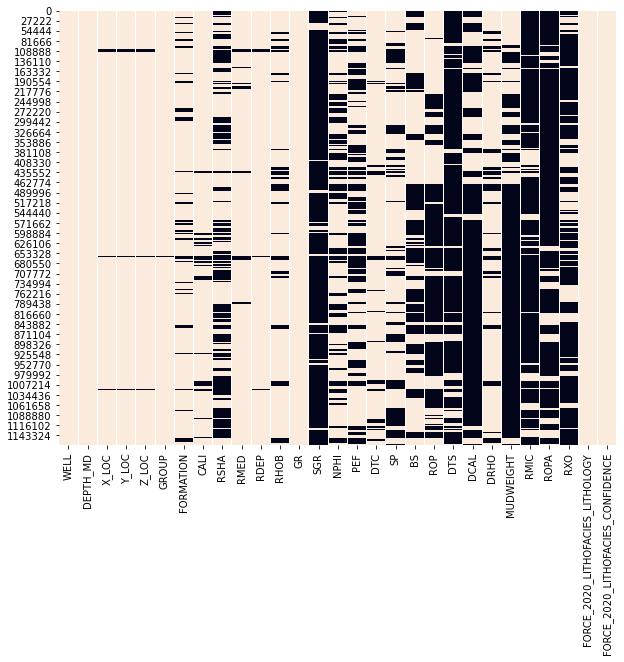

In [10]:
plot_null_matrix(logs_data)

Looking at the plot, it is obvious that there are some columns with a noticeable amount of missing data. We will generate a table with the count of null values and the percentage of the data missing for each column.

In [11]:
null_count = logs_data.isnull().sum()
null_pct = (null_count / logs_data.shape[0]) * 100

null_values = pd.DataFrame({'null_count': null_count,
                           'null_pct': null_pct})
null_values

,null_count,null_pct
WELL,0,0.000000
DEPTH_MD,0,0.000000
X_LOC,10775,0.920538
Y_LOC,10775,0.920538
Z_LOC,10775,0.920538
GROUP,1278,0.109183
FORMATION,136994,11.703777
CALI,87877,7.507576
RSHA,539861,46.121822
RMED,38993,3.331280


 Then we can plot these data to visually determine a threshold value for the percentage of missing data we will allow for the features to be used in our machine learning algorithm.

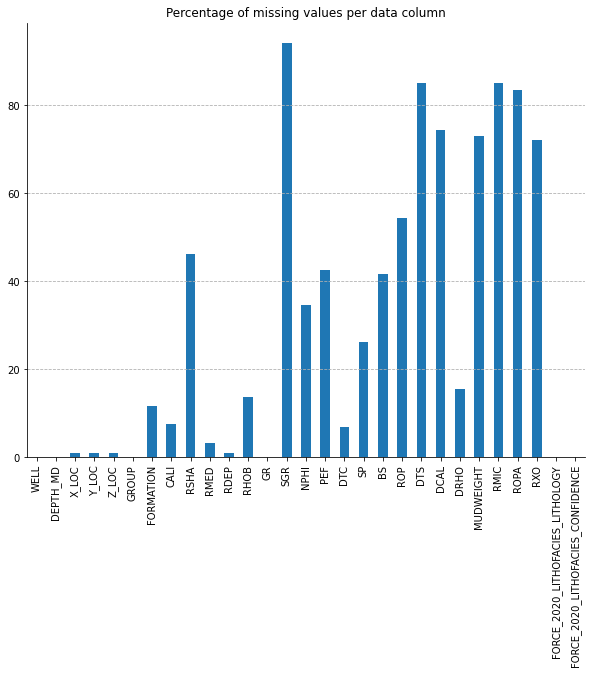

In [12]:
null_values['null_pct'].plot(kind='bar', figsize=(10,8), title=
                            'Percentage of missing values per data column')

sns.despine()
plt.grid(axis='y', ls='--')

plt.show()

We will select only features with less than 45 percent of missing data.

In [13]:
features = null_values[null_values['null_pct'] < 45].index
features

Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS',
       'DRHO', 'FORCE_2020_LITHOFACIES_LITHOLOGY',
       'FORCE_2020_LITHOFACIES_CONFIDENCE'],
      dtype='object')

## Distribution of values per feature

Now we will explore the feature distribution for each data column. First we will display boxplots to see if there are any outliers.

In [14]:
logs_ml = features.drop(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC',
                               'Z_LOC', 'GROUP', 'FORMATION',
                               'FORCE_2020_LITHOFACIES_LITHOLOGY',
                               'FORCE_2020_LITHOFACIES_CONFIDENCE'])

logs_ml

Index(['CALI', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS',
       'DRHO'],
      dtype='object')

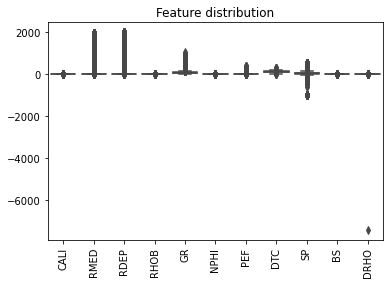

In [15]:
fig, ax = plt.subplots()

ax = sns.boxplot(data=logs_data[logs_ml])
ax.set_title('Feature distribution')
plt.xticks(rotation=90)

plt.show()

## Pairplots

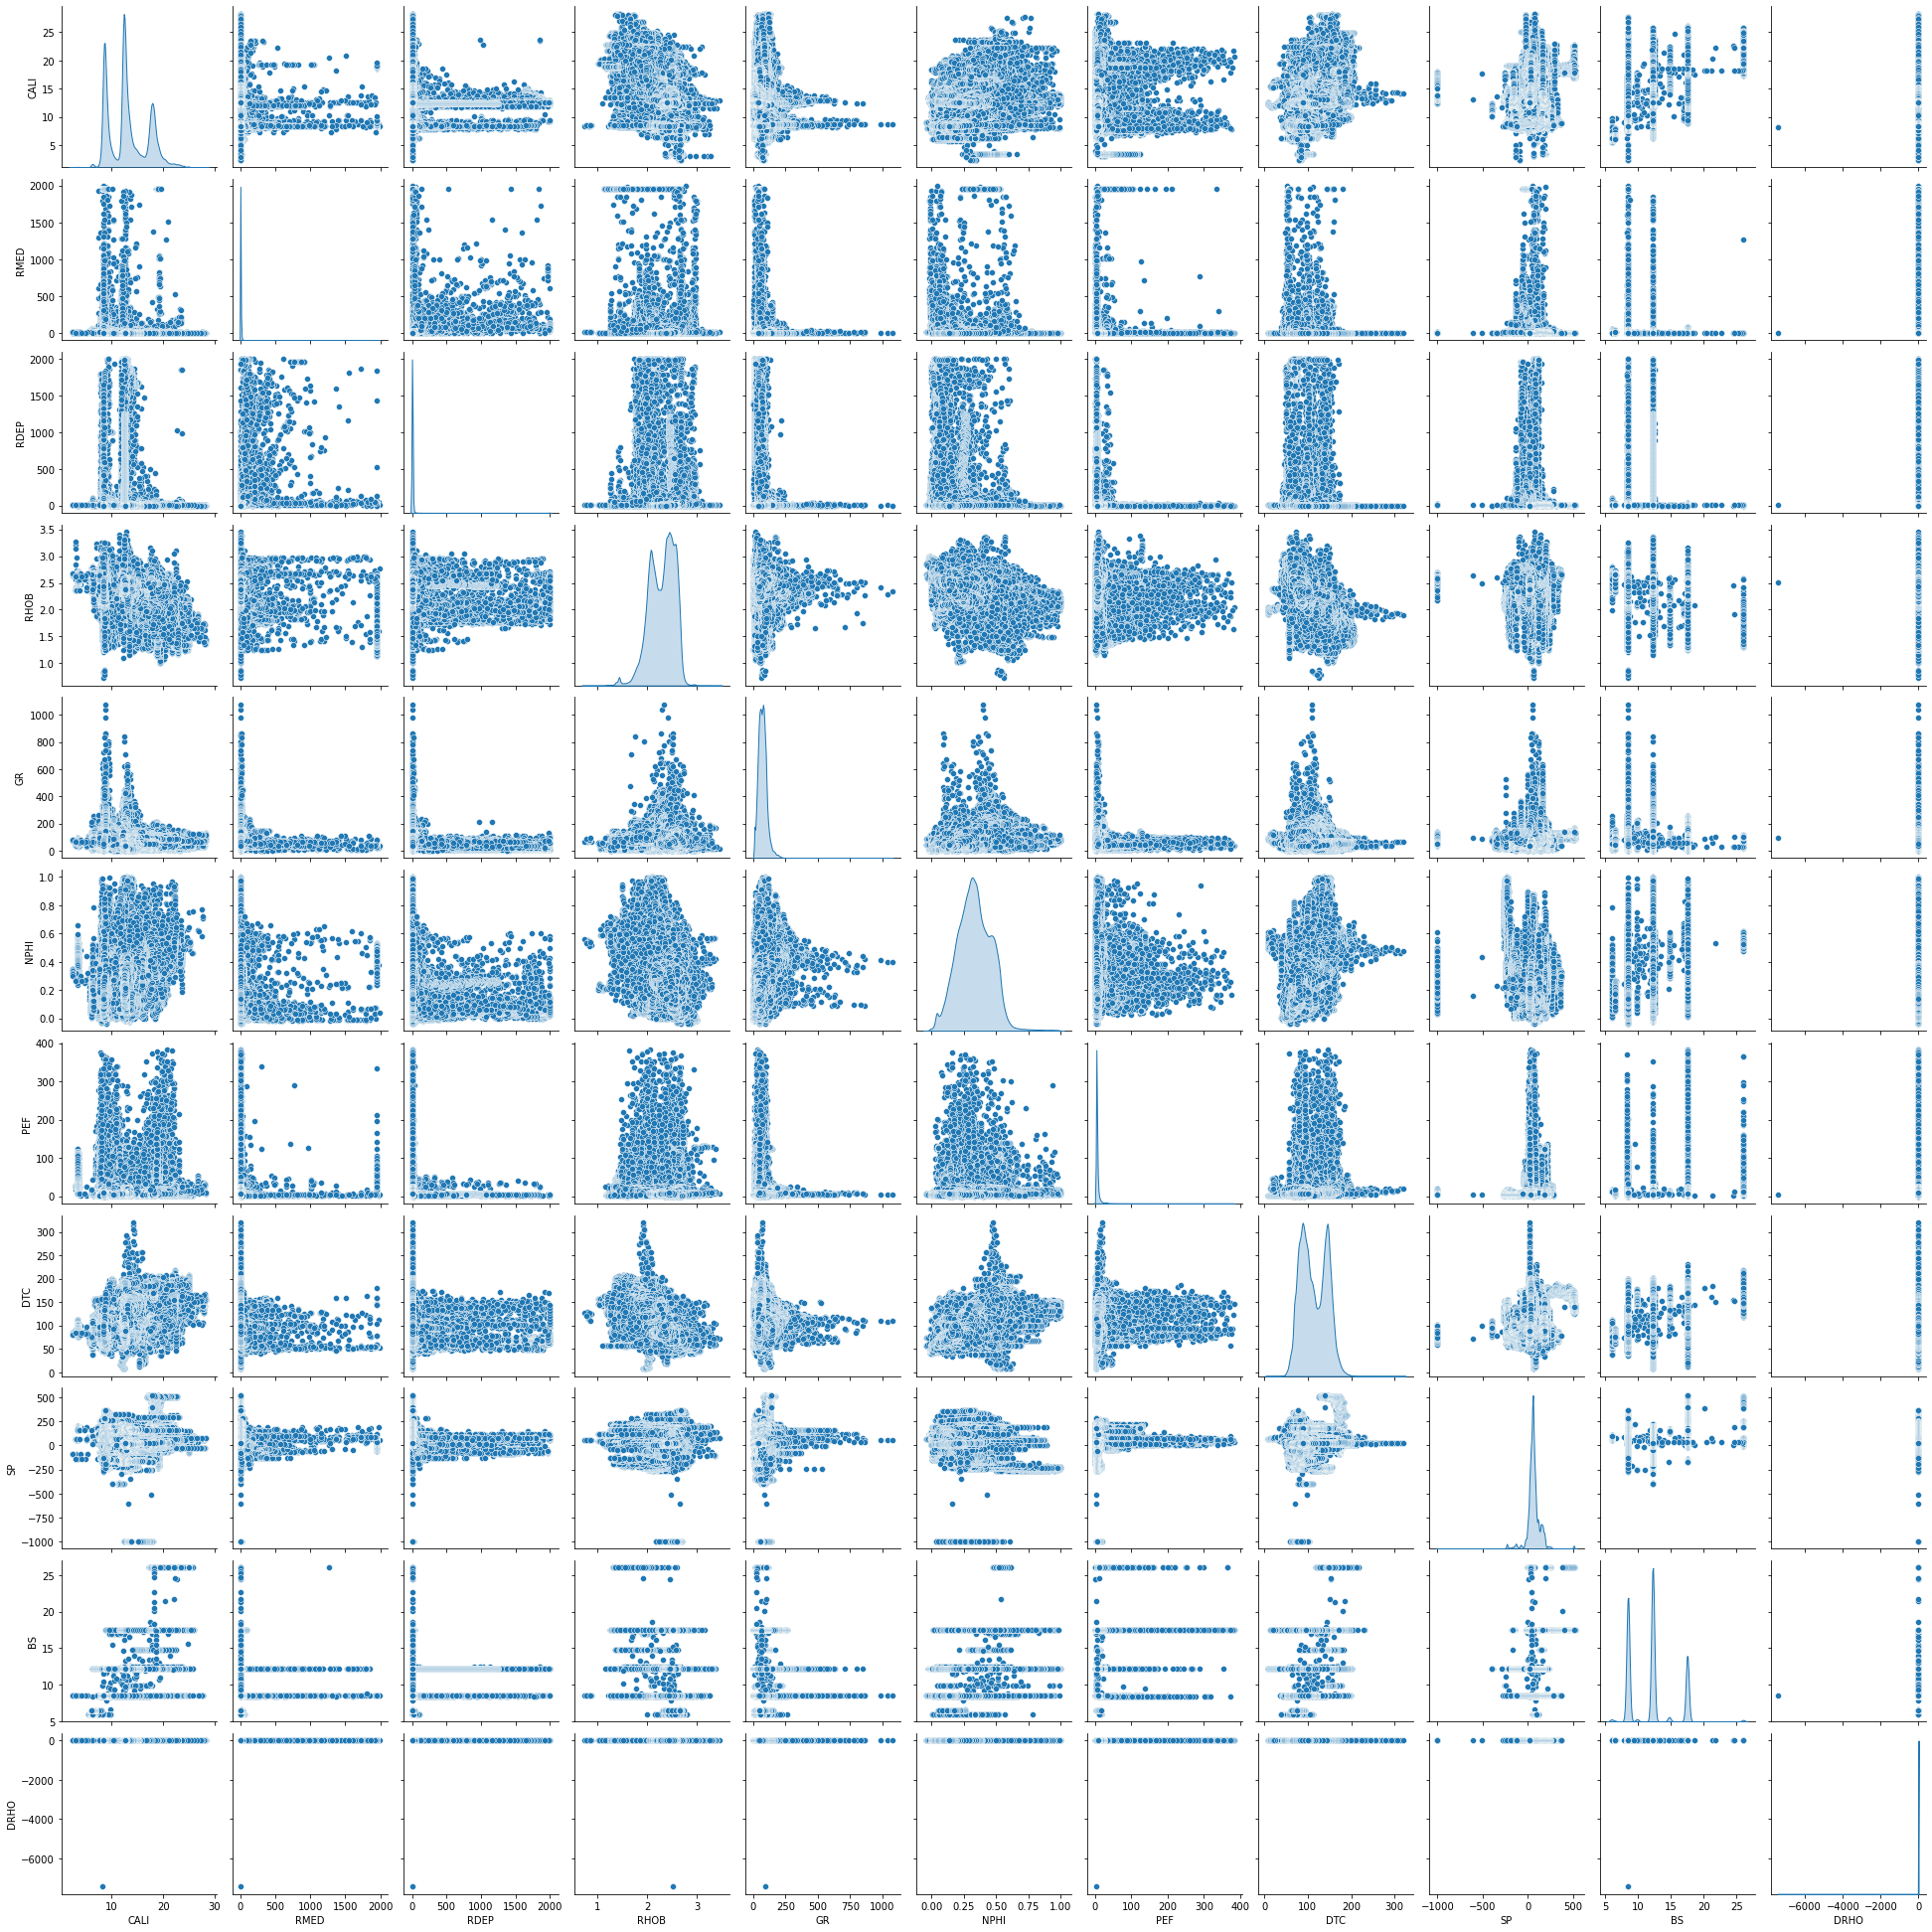

In [16]:
sns.pairplot(logs_data, vars=logs_ml, diag_kind='kde')

plt.show()

Looking at the boxplot and pairplots we can make the following inferences:

- Value ranges probably are very different, and thus, some features are outscaled, making it difficult to visualize their distribution.
- The features do contain some outliers. An example of this is the `DRHO` data column, with an outlier that might be the result of an incorrect measurement or a tool error.
- Some features have a distribution that resembles a normal distribution (also known as Gaussian distribution), although skewed, other features have multimodal distributions.

To make the visualization of the feature distributions easier we can normalize the data, a data processing step already required in the machine learning workflow.

## Is the dataset balanced?

So far, we have performed EDA (Exploratory Data Analysis) for our features. Now we will explore our target column, which is the `FORCE_2020_LITHOFACIES_LITHOLOGY`. Doing so will also allow us to answer wether our dataset is balanced. A dataset is balanced when it contains an almost equal percentage of examples per class. In the case of a binary classification problem this would mean a distribution of 50% positive class examples and 50% negative class examples, or 60% positive class examples and 40% negative class examples or vice-versa.

First, we will calculate the theoretical relative frequency (the percentage of examples for each class) for our dataset to be balanced.

In [17]:
# For readability transform original lithology codes into labels
# (lithology code correspondance was given in the competition starter notebook).
lithology_keys = {30000: 'Sandstone',
                 65030: 'Sandstone/Shale',
                 65000: 'Shale',
                 80000: 'Marl',
                 74000: 'Dolomite',
                 70000: 'Limestone',
                 70032: 'Chalk',
                 88000: 'Halite',
                 86000: 'Anhydrite',
                 99000: 'Tuff',
                 90000: 'Coal',
                 93000: 'Basement'}

In [18]:
label = 'FORCE_2020_LITHOFACIES_LITHOLOGY'

unique_lithologies = logs_data[label].unique()
theoretical_pct_lithology = 100 / unique_lithologies.shape[0]
theoretical_pct_lithology

8.333333333333334

In [19]:
lithologies_labels = logs_data[label].map(lithology_keys)

lithologies_count = lithologies_labels.value_counts(normalize=True) * 100
lithologies_count

Shale              61.580199
Sandstone          14.432756
Sandstone/Shale    12.853788
Limestone           4.811574
Marl                2.847389
Tuff                1.302423
Chalk               0.898155
Halite              0.701659
Coal                0.326353
Dolomite            0.144211
Anhydrite           0.092695
Basement            0.008800
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, dtype: float64

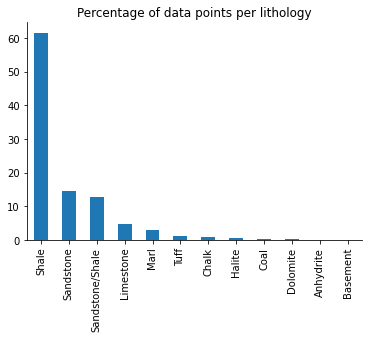

In [20]:
lithologies_count.plot(kind='bar',
                      title='Percentage of data points per lithology')
sns.despine()

plt.show()

We can see that the dataset is imbalanced, one class represents over 60 percent of the data points in our dataset. In order to see if our evaluation score for the model improves after balancing the dataset we will first evaluate the model in this imbalanced data.

# Data processing

## Handling missing data

For simplicity reasons, we will perform data imputation on the numerical columns by replacing the missing values with the mean of each column. We will also work with a subset of our original dataset, which will drop columns like `DEPTH_MD`, `X_LOC`, `Y_LOC`, and `FORCE_2020_LITHOFACIES_CONFIDENCE`.

In [21]:
columns = features.drop(['DEPTH_MD', 'X_LOC', 'Y_LOC',
                         'FORCE_2020_LITHOFACIES_CONFIDENCE'])
columns

Index(['WELL', 'Z_LOC', 'GROUP', 'FORMATION', 'CALI', 'RMED', 'RDEP', 'RHOB',
       'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS', 'DRHO',
       'FORCE_2020_LITHOFACIES_LITHOLOGY'],
      dtype='object')

In [22]:
ml_data = logs_data[columns]
ml_data

,WELL,Z_LOC,GROUP,FORMATION,CALI,RMED,RDEP,RHOB,GR,NPHI,PEF,DTC,SP,BS,DRHO,FORCE_2020_LITHOFACIES_LITHOLOGY
0,15/9-13,-469.501831,NORDLAND GP.,NaN,19.480835,1.611410,1.798681,1.884186,80.200851,NaN,20.915468,161.131180,24.612379,NaN,-0.574928,65000
1,15/9-13,-469.653809,NORDLAND GP.,NaN,19.468800,1.618070,1.795641,1.889794,79.262886,NaN,19.383013,160.603470,23.895531,NaN,-0.570188,65000
2,15/9-13,-469.805786,NORDLAND GP.,NaN,19.468800,1.626459,1.800733,1.896523,74.821999,NaN,22.591518,160.173615,23.916357,NaN,-0.574245,65000
3,15/9-13,-469.957794,NORDLAND GP.,NaN,19.459282,1.621594,1.801517,1.891913,72.878922,NaN,32.191910,160.149429,23.793688,NaN,-0.586315,65000
4,15/9-13,-470.109772,NORDLAND GP.,NaN,19.453100,1.602679,1.795299,1.880034,71.729141,NaN,38.495632,160.128342,24.104078,NaN,-0.597914,65000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1170506,7/1-2 S,NaN,VESTLAND GP.,Bryne Fm.,8.423170,NaN,NaN,2.527984,77.654900,NaN,4.586425,NaN,NaN,8.5,-0.001763,30000
1170507,7/1-2 S,NaN,VESTLAND GP.,Bryne Fm.,8.379244,NaN,NaN,2.537613,75.363937,NaN,7.019858,NaN,NaN,8.5,-0.007600,65030
1170508,7/1-2 S,NaN,VESTLAND GP.,Bryne Fm.,8.350248,NaN,NaN,2.491860,66.452843,NaN,9.049782,NaN,NaN,8.5,-0.018297,65030
1170509,7/1-2 S,NaN,VESTLAND GP.,Bryne Fm.,8.313779,NaN,NaN,2.447539,55.784817,NaN,8.903917,NaN,NaN,8.5,-0.011438,65030


In [23]:
ml_data_num = ml_data.select_dtypes(include=np.number).drop(label, axis=1)
print(ml_data_num.columns)

ml_data_num = ml_data_num.fillna(ml_data_num.mean())
ml_data_num.isnull().sum()

Index(['Z_LOC', 'CALI', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC',
       'SP', 'BS', 'DRHO'],
      dtype='object')


Z_LOC    0
CALI     0
RMED     0
RDEP     0
RHOB     0
GR       0
NPHI     0
PEF      0
DTC      0
SP       0
BS       0
DRHO     0
dtype: int64

For the categorical data, replacing null values with an specific lithology would imply thorough geological analysis. For simplicity we will replace null values with the string `Unknown`.

In [24]:
ml_data_categorical = ml_data.select_dtypes(include=np.object)

ml_data_categorical = ml_data_categorical.fillna('Unknown')
ml_data_categorical.isnull().sum()

WELL         0
GROUP        0
FORMATION    0
dtype: int64

In [25]:
ml_data_clean = pd.concat([ml_data_categorical, ml_data_num], axis=1)
ml_data_clean

,WELL,GROUP,FORMATION,Z_LOC,CALI,RMED,RDEP,RHOB,GR,NPHI,PEF,DTC,SP,BS,DRHO
0,15/9-13,NORDLAND GP.,Unknown,-469.501831,19.480835,1.611410,1.798681,1.884186,80.200851,0.331966,20.915468,161.131180,24.612379,11.931432,-0.574928
1,15/9-13,NORDLAND GP.,Unknown,-469.653809,19.468800,1.618070,1.795641,1.889794,79.262886,0.331966,19.383013,160.603470,23.895531,11.931432,-0.570188
2,15/9-13,NORDLAND GP.,Unknown,-469.805786,19.468800,1.626459,1.800733,1.896523,74.821999,0.331966,22.591518,160.173615,23.916357,11.931432,-0.574245
3,15/9-13,NORDLAND GP.,Unknown,-469.957794,19.459282,1.621594,1.801517,1.891913,72.878922,0.331966,32.191910,160.149429,23.793688,11.931432,-0.586315
4,15/9-13,NORDLAND GP.,Unknown,-470.109772,19.453100,1.602679,1.795299,1.880034,71.729141,0.331966,38.495632,160.128342,24.104078,11.931432,-0.597914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1170506,7/1-2 S,VESTLAND GP.,Bryne Fm.,-2138.527143,8.423170,4.986978,10.691026,2.527984,77.654900,0.331966,4.586425,113.358084,60.033980,8.500000,-0.001763
1170507,7/1-2 S,VESTLAND GP.,Bryne Fm.,-2138.527143,8.379244,4.986978,10.691026,2.537613,75.363937,0.331966,7.019858,113.358084,60.033980,8.500000,-0.007600
1170508,7/1-2 S,VESTLAND GP.,Bryne Fm.,-2138.527143,8.350248,4.986978,10.691026,2.491860,66.452843,0.331966,9.049782,113.358084,60.033980,8.500000,-0.018297
1170509,7/1-2 S,VESTLAND GP.,Bryne Fm.,-2138.527143,8.313779,4.986978,10.691026,2.447539,55.784817,0.331966,8.903917,113.358084,60.033980,8.500000,-0.011438


In [26]:
ml_data_clean['LITHOLOGY'] = ml_data[label].map(lithology_keys)
ml_data_clean.isnull().sum()

WELL         0
GROUP        0
FORMATION    0
Z_LOC        0
CALI         0
RMED         0
RDEP         0
RHOB         0
GR           0
NPHI         0
PEF          0
DTC          0
SP           0
BS           0
DRHO         0
LITHOLOGY    0
dtype: int64

## Scaling the data

As mentioned earlier in the notebook, the value ranges for the features are very different, with some having maximum values that are in a different order of magnitude. We will scale the data so that the features are not outscaled. 

Data scaling is also considered a best practice for machine learning workflows, since it decreases training time, avoids the algorithm to show some "preference" to columns with higher magnitudes, and prevents problems such as numerical overflow. There are two widely used data scaling techniques:

- Min-max normalization: Values are scaled to a range from 0 to 1, by using the formula:

$$scaled\;data = \frac{x_i - min(x)}{max(x) - min(x)}$$
- Standardization (Z-score normalization): Values are scaled so that their distribution is described in terms of how much they deviate from the mean of the distribution.
$$scaled\;data = \frac{x_i - \mu}{\sigma}$$

For our data we will use another scaling strategy, we will use the `PowerTransformer()` class to build a scaler that uses a power transform (specifically, the "yeo-johnson" method) to scale our data and make the distribution of features more Gaussian-like, which in some cases helps in making training the modeling algorithm easier.

However, before doing so, we will transform some of the data with large ranges into logarithmic scale. Through a quick search on the internet or using domain knowledge, you can find that there are two features in our dataset that are normally plotted in logarithmic scale due to their large value ranges. This features are the resisitivity logs.

In [27]:
# transform resisitivity logs into logarithmic scale
ml_data_clean['RMED'] = np.log10(ml_data_clean['RMED'])
ml_data_clean['RMED'] = np.log10(ml_data_clean['RDEP'])

C:\Users\Angel\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [28]:
# generate PowerTransfomer instance
scaler = PowerTransformer(method='yeo-johnson')

# initialize ColumnTransformer instance
ct = ColumnTransformer([('scaler', scaler, logs_ml)],
                      remainder='passthrough')

ml_data_norm = ct.fit_transform(ml_data_clean)
ml_data_norm

array([[1.5689912275097166, 0.2486494060957612, 0.20783885430564225, ...,
        'Unknown', -469.50183110000006, 'Shale'],
       [1.5666240027409932, 0.24676390577291818, 0.2055382336439452, ...,
        'Unknown', -469.6538086, 'Shale'],
       [1.5666240027409932, 0.24991934300156396, 0.2093888463955194, ...,
        'Unknown', -469.80578610000003, 'Shale'],
       ...,
       [-1.4722701998916912, 1.6346457776087622, 1.8002290920693833, ...,
        'Bryne Fm.', -2138.5271425447368, 'Sandstone/Shale'],
       [-1.4868594357887681, 1.6346457776087622, 1.8002290920693833, ...,
        'Bryne Fm.', -2138.5271425447368, 'Sandstone/Shale'],
       [-1.4944278375104374, 1.6346457776087622, 1.8002290920693833, ...,
        'Bryne Fm.', -2138.5271425447368, 'Sandstone/Shale']],
      dtype=object)

In [29]:
df_cols = np.append(logs_ml, ['WELL', 'GROUP', 'FORMATION', 'Z_LOC',
                             'LITHOLOGY'])
ml_data_norm = pd.DataFrame(ml_data_norm, columns=df_cols)
ml_data_norm

,CALI,RMED,RDEP,RHOB,GR,NPHI,PEF,DTC,SP,BS,DRHO,WELL,GROUP,FORMATION,Z_LOC,LITHOLOGY
0,1.56899,0.248649,0.207839,-1.59668,0.39483,0.0327833,2.57258,1.56265,-0.653382,0.115317,-1.78822,15/9-13,NORDLAND GP.,Unknown,-469.502,Shale
1,1.56662,0.246764,0.205538,-1.57899,0.368797,0.0327833,2.46553,1.54731,-0.664776,0.115317,-1.77586,15/9-13,NORDLAND GP.,Unknown,-469.654,Shale
2,1.56662,0.249919,0.209389,-1.55765,0.24323,0.0327833,2.67732,1.53479,-0.664446,0.115317,-1.78644,15/9-13,NORDLAND GP.,Unknown,-469.806,Shale
3,1.56475,0.250404,0.20998,-1.57228,0.18703,0.0327833,3.11326,1.53408,-0.666393,0.115317,-1.81786,15/9-13,NORDLAND GP.,Unknown,-469.958,Shale
4,1.56353,0.246551,0.205279,-1.60972,0.153395,0.0327833,3.30713,1.53347,-0.661464,0.115317,-1.84792,15/9-13,NORDLAND GP.,Unknown,-470.11,Shale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1170506,-1.44325,1.63465,1.80023,1.08109,0.323779,0.0327833,-0.318391,0.0606547,-0.0661068,-1.5483,-0.0968679,7/1-2 S,VESTLAND GP.,Bryne Fm.,-2138.53,Sandstone
1170507,-1.46071,1.63465,1.80023,1.13215,0.258765,0.0327833,0.656712,0.0606547,-0.0661068,-1.5483,-0.1166,7/1-2 S,VESTLAND GP.,Bryne Fm.,-2138.53,Sandstone/Shale
1170508,-1.47227,1.63465,1.80023,0.892694,-0.0048011,0.0327833,1.17817,0.0606547,-0.0661068,-1.5483,-0.15259,7/1-2 S,VESTLAND GP.,Bryne Fm.,-2138.53,Sandstone/Shale
1170509,-1.48686,1.63465,1.80023,0.668305,-0.346688,0.0327833,1.14621,0.0606547,-0.0661068,-1.5483,-0.129537,7/1-2 S,VESTLAND GP.,Bryne Fm.,-2138.53,Sandstone/Shale


The `fit_transform()` method not only removed the column names, but also stored all information as object dtype.

In [30]:
ml_data_norm.dtypes

CALI         object
RMED         object
RDEP         object
RHOB         object
GR           object
NPHI         object
PEF          object
DTC          object
SP           object
BS           object
DRHO         object
WELL         object
GROUP        object
FORMATION    object
Z_LOC        object
LITHOLOGY    object
dtype: object

In [31]:
ml_data_norm[logs_ml] = ml_data_norm[logs_ml].astype(float)
ml_data_norm['Z_LOC'] = ml_data_norm['Z_LOC'].astype(float)
ml_data_norm.dtypes

CALI         float64
RMED         float64
RDEP         float64
RHOB         float64
GR           float64
NPHI         float64
PEF          float64
DTC          float64
SP           float64
BS           float64
DRHO         float64
WELL          object
GROUP         object
FORMATION     object
Z_LOC        float64
LITHOLOGY     object
dtype: object

## Outlier removal 

There are many techniques for outlier removal. Perhaps the most widely known is the standard deviation method, where we compute the absolute value of the difference between each feature example and its mean and keep only those examples where the difference is less than or equal to three times the standard deviation of the feature. There are other statistical techniques, but for now we will use the standard deviation method.

In [32]:
ml_features = ml_data_norm[logs_ml].copy()

ml_train_std = ml_features[np.abs(ml_features - ml_features.mean()) <= 
                           (3 * ml_features.std())]

ml_train_std = ml_train_std.dropna()
train_norm = ml_data_norm.loc[ml_train_std.index]

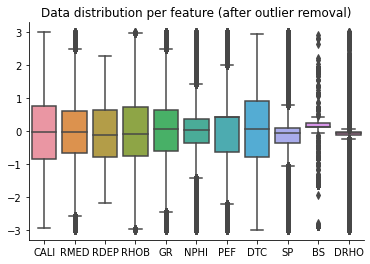

In [33]:
sns.boxplot(data=ml_train_std)

sns.despine()
plt.title('Data distribution per feature (after outlier removal)')

plt.show()

## Encoding target and categorical features

Some machine learning algorithms, like decision trees and random forest can work with categorical features in string format, most of them require the target and the features to be of a numeric data type. We can use pandas methods to transform columns to categorical type and access the integer used to code them. 

In practice, One-Hot encoding often yields better results. This encoding consists of generating one column per unique value of each categorical feature, which will store the number one if the feature is present for the data example and a zero otherwise.

*Note: For our dataframe this step is done merely as an example, as we already know we are not going to use the categorical feature columns.*

In [34]:
train_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1096326 entries, 0 to 1170510
Data columns (total 16 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   CALI       1096326 non-null  float64
 1   RMED       1096326 non-null  float64
 2   RDEP       1096326 non-null  float64
 3   RHOB       1096326 non-null  float64
 4   GR         1096326 non-null  float64
 5   NPHI       1096326 non-null  float64
 6   PEF        1096326 non-null  float64
 7   DTC        1096326 non-null  float64
 8   SP         1096326 non-null  float64
 9   BS         1096326 non-null  float64
 10  DRHO       1096326 non-null  float64
 11  WELL       1096326 non-null  object 
 12  GROUP      1096326 non-null  object 
 13  FORMATION  1096326 non-null  object 
 14  Z_LOC      1096326 non-null  float64
 15  LITHOLOGY  1096326 non-null  object 
dtypes: float64(12), object(4)
memory usage: 142.2+ MB


In [35]:
categorical_labels = ['WELL', 'GROUP', 'FORMATION']
target = 'LITHOLOGY'

train_norm[categorical_labels] = train_norm[categorical_labels]\
.astype('category')
train_norm[target] = train_norm[target].astype('category')

train_norm.dtypes

CALI          float64
RMED          float64
RDEP          float64
RHOB          float64
GR            float64
NPHI          float64
PEF           float64
DTC           float64
SP            float64
BS            float64
DRHO          float64
WELL         category
GROUP        category
FORMATION    category
Z_LOC         float64
LITHOLOGY    category
dtype: object

Now we are going to explore the categorical features to see how many unique values each one has.

In [36]:
train_norm[categorical_labels].describe()

,WELL,GROUP,FORMATION
count,1096326,1096326,1096326
unique,98,15,70
top,34/2-4,HORDALAND GP.,Utsira Fm.
freq,23224,278449,160838


We can see that there many unique wells and formations. One-Hot encoding would result in a dataframe with a much higher dimensionality. This would limit the options of machine learning algorithms that we can use.

In [37]:
dummy_cols = pd.get_dummies(train_norm[categorical_labels])
dummy_cols

,WELL_15/9-13,WELL_15/9-15,WELL_15/9-17,WELL_16/1-2,WELL_16/1-6 A,WELL_16/10-1,WELL_16/10-2,WELL_16/10-3,WELL_16/10-5,WELL_16/11-1 ST3,WELL_16/2-11 A,WELL_16/2-16,WELL_16/2-6,WELL_16/4-1,WELL_16/5-3,WELL_16/7-4,WELL_16/7-5,WELL_16/8-1,WELL_17/11-1,WELL_25/11-15,WELL_25/11-19 S,WELL_25/11-5,WELL_25/2-13 T4,WELL_25/2-14,WELL_25/2-7,WELL_25/3-1,WELL_25/4-5,WELL_25/5-1,WELL_25/5-4,WELL_25/6-1,WELL_25/6-2,WELL_25/6-3,WELL_25/7-2,WELL_25/8-5 S,WELL_25/8-7,WELL_25/9-1,WELL_26/4-1,WELL_29/6-1,WELL_30/3-3,WELL_30/3-5 S,WELL_30/6-5,WELL_31/2-1,WELL_31/2-19 S,WELL_31/2-7,WELL_31/2-8,WELL_31/2-9,WELL_31/3-1,WELL_31/3-2,WELL_31/3-3,WELL_31/3-4,WELL_31/4-10,WELL_31/4-5,WELL_31/5-4 S,WELL_31/6-5,WELL_31/6-8,WELL_32/2-1,WELL_33/5-2,WELL_33/6-3 S,WELL_33/9-1,WELL_33/9-17,WELL_34/10-19,WELL_34/10-21,WELL_34/10-33,WELL_34/10-35,WELL_34/11-1,WELL_34/11-2 S,WELL_34/12-1,WELL_34/2-4,WELL_34/3-1 A,WELL_34/4-10 R,WELL_34/5-1 A,WELL_34/5-1 S,WELL_34/7-13,WELL_34/7-20,WELL_34/7-21,WELL_34/8-1,WELL_34/8-3,WELL_34/8-7 R,WELL_35/11-1,WELL_35/11-10,WELL_35/11-11,WELL_35/11-12,WELL_35/11-13,WELL_35/11-15 S,WELL_35/11-6,WELL_35/11-7,WELL_35/12-1,WELL_35/3-7 S,WELL_35/4-1,WELL_35/8-4,WELL_35/8-6 S,WELL_35/9-10 S,WELL_35/9-2,WELL_35/9-5,WELL_35/9-6 S,WELL_36/7-3,WELL_7/1-1,WELL_7/1-2 S,GROUP_BAAT GP.,GROUP_BOKNFJORD GP.,GROUP_CROMER KNOLL GP.,GROUP_DUNLIN GP.,GROUP_HEGRE GP.,GROUP_HORDALAND GP.,GROUP_NORDLAND GP.,GROUP_ROGALAND GP.,GROUP_ROTLIEGENDES GP.,GROUP_SHETLAND GP.,GROUP_TYNE GP.,GROUP_Unknown,GROUP_VESTLAND GP.,GROUP_VIKING GP.,GROUP_ZECHSTEIN GP.,FORMATION_Aasgard Fm.,FORMATION_Agat Fm.,FORMATION_Amundsen Fm.,FORMATION_BASEMENT,FORMATION_Balder Fm.,FORMATION_Blodoeks Fm.,FORMATION_Broom Fm.,FORMATION_Bryne Fm.,FORMATION_Burton Fm.,FORMATION_Cook Fm.,FORMATION_Drake Fm.,FORMATION_Draupne Fm.,FORMATION_Egersund Fm.,FORMATION_Eiriksson Mb.,FORMATION_Ekofisk Fm.,FORMATION_Etive Fm.,FORMATION_Farsund Fm.,FORMATION_Fensfjord Fm.,FORMATION_Flekkefjord Fm.,FORMATION_Frigg Fm.,FORMATION_Grid Fm.,FORMATION_Grid Mb.,FORMATION_Hardraade Fm.,FORMATION_Heather Fm.,FORMATION_Heimdal Fm.,FORMATION_Hermod Mb.,FORMATION_Hidra Fm.,FORMATION_Hod Fm.,FORMATION_Hugin Fm.,FORMATION_Intra Balder Fm. Sst.,FORMATION_Intra Draupne Fm. Sst.,FORMATION_Intra Heather Fm. Sst.,FORMATION_Johansen Fm.,FORMATION_Jorsalfare Fm.,FORMATION_Krossfjord Fm.,FORMATION_Kupferschiefer Fm.,FORMATION_Kyrre Fm.,FORMATION_Lista Fm.,FORMATION_Lunde Fm.,FORMATION_Mandal Fm.,FORMATION_Mime Fm.,FORMATION_Ness Fm.,FORMATION_Oseberg Fm.,FORMATION_Ran Sst Mb.,FORMATION_Rannoch Fm.,FORMATION_Raude Mb.,FORMATION_Roedby Fm.,FORMATION_Sandnes Fm.,FORMATION_Sauda Fm.,FORMATION_Sele Fm.,FORMATION_Skade Fm.,FORMATION_Skade Mb.,FORMATION_Skagerrak Fm.,FORMATION_Sleipner Fm.,FORMATION_Smith Bank Fm.,FORMATION_Sognefjord Fm.,FORMATION_Sola Fm.,FORMATION_Statfjord Fm.,FORMATION_Svarte Fm.,FORMATION_Tarbert Fm.,FORMATION_Tau Fm.,FORMATION_Tor Fm.,FORMATION_Tryggvason Fm.,FORMATION_Tuxen Fm.,FORMATION_Ty Fm.,FORMATION_Ty Mb.,FORMATION_Ula Fm.,FORMATION_Unknown,FORMATION_Utsira Fm.,FORMATION_Vaale Fm.
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [38]:
train_norm = train_norm.drop(['WELL', 'GROUP', 'FORMATION'], axis=1)
train_coded = pd.concat([train_norm, dummy_cols], axis=1)
train_coded

,CALI,RMED,RDEP,RHOB,GR,NPHI,PEF,DTC,SP,BS,DRHO,Z_LOC,LITHOLOGY,WELL_15/9-13,WELL_15/9-15,WELL_15/9-17,WELL_16/1-2,WELL_16/1-6 A,WELL_16/10-1,WELL_16/10-2,WELL_16/10-3,WELL_16/10-5,WELL_16/11-1 ST3,WELL_16/2-11 A,WELL_16/2-16,WELL_16/2-6,WELL_16/4-1,WELL_16/5-3,WELL_16/7-4,WELL_16/7-5,WELL_16/8-1,WELL_17/11-1,WELL_25/11-15,WELL_25/11-19 S,WELL_25/11-5,WELL_25/2-13 T4,WELL_25/2-14,WELL_25/2-7,WELL_25/3-1,WELL_25/4-5,WELL_25/5-1,WELL_25/5-4,WELL_25/6-1,WELL_25/6-2,WELL_25/6-3,WELL_25/7-2,WELL_25/8-5 S,WELL_25/8-7,WELL_25/9-1,WELL_26/4-1,WELL_29/6-1,WELL_30/3-3,WELL_30/3-5 S,WELL_30/6-5,WELL_31/2-1,WELL_31/2-19 S,WELL_31/2-7,WELL_31/2-8,WELL_31/2-9,WELL_31/3-1,WELL_31/3-2,WELL_31/3-3,WELL_31/3-4,WELL_31/4-10,WELL_31/4-5,WELL_31/5-4 S,WELL_31/6-5,WELL_31/6-8,WELL_32/2-1,WELL_33/5-2,WELL_33/6-3 S,WELL_33/9-1,WELL_33/9-17,WELL_34/10-19,WELL_34/10-21,WELL_34/10-33,WELL_34/10-35,WELL_34/11-1,WELL_34/11-2 S,WELL_34/12-1,WELL_34/2-4,WELL_34/3-1 A,WELL_34/4-10 R,WELL_34/5-1 A,WELL_34/5-1 S,WELL_34/7-13,WELL_34/7-20,WELL_34/7-21,WELL_34/8-1,WELL_34/8-3,WELL_34/8-7 R,WELL_35/11-1,WELL_35/11-10,WELL_35/11-11,WELL_35/11-12,WELL_35/11-13,WELL_35/11-15 S,WELL_35/11-6,WELL_35/11-7,WELL_35/12-1,WELL_35/3-7 S,WELL_35/4-1,WELL_35/8-4,WELL_35/8-6 S,WELL_35/9-10 S,WELL_35/9-2,WELL_35/9-5,WELL_35/9-6 S,WELL_36/7-3,WELL_7/1-1,WELL_7/1-2 S,GROUP_BAAT GP.,GROUP_BOKNFJORD GP.,GROUP_CROMER KNOLL GP.,GROUP_DUNLIN GP.,GROUP_HEGRE GP.,GROUP_HORDALAND GP.,GROUP_NORDLAND GP.,GROUP_ROGALAND GP.,GROUP_ROTLIEGENDES GP.,GROUP_SHETLAND GP.,GROUP_TYNE GP.,GROUP_Unknown,GROUP_VESTLAND GP.,GROUP_VIKING GP.,GROUP_ZECHSTEIN GP.,FORMATION_Aasgard Fm.,FORMATION_Agat Fm.,FORMATION_Amundsen Fm.,FORMATION_BASEMENT,FORMATION_Balder Fm.,FORMATION_Blodoeks Fm.,FORMATION_Broom Fm.,FORMATION_Bryne Fm.,FORMATION_Burton Fm.,FORMATION_Cook Fm.,FORMATION_Drake Fm.,FORMATION_Draupne Fm.,FORMATION_Egersund Fm.,FORMATION_Eiriksson Mb.,FORMATION_Ekofisk Fm.,FORMATION_Etive Fm.,FORMATION_Farsund Fm.,FORMATION_Fensfjord Fm.,FORMATION_Flekkefjord Fm.,FORMATION_Frigg Fm.,FORMATION_Grid Fm.,FORMATION_Grid Mb.,FORMATION_Hardraade Fm.,FORMATION_Heather Fm.,FORMATION_Heimdal Fm.,FORMATION_Hermod Mb.,FORMATION_Hidra Fm.,FORMATION_Hod Fm.,FORMATION_Hugin Fm.,FORMATION_Intra Balder Fm. Sst.,FORMATION_Intra Draupne Fm. Sst.,FORMATION_Intra Heather Fm. Sst.,FORMATION_Johansen Fm.,FORMATION_Jorsalfare Fm.,FORMATION_Krossfjord Fm.,FORMATION_Kupferschiefer Fm.,FORMATION_Kyrre Fm.,FORMATION_Lista Fm.,FORMATION_Lunde Fm.,FORMATION_Mandal Fm.,FORMATION_Mime Fm.,FORMATION_Ness Fm.,FORMATION_Oseberg Fm.,FORMATION_Ran Sst Mb.,FORMATION_Rannoch Fm.,FORMATION_Raude Mb.,FORMATION_Roedby Fm.,FORMATION_Sandnes Fm.,FORMATION_Sauda Fm.,FORMATION_Sele Fm.,FORMATION_Skade Fm.,FORMATION_Skade Mb.,FORMATION_Skagerrak Fm.,FORMATION_Sleipner Fm.,FORMATION_Smith Bank Fm.,FORMATION_Sognefjord Fm.,FORMATION_Sola Fm.,FORMATION_Statfjord Fm.,FORMATION_Svarte Fm.,FORMATION_Tarbert Fm.,FORMATION_Tau Fm.,FORMATION_Tor Fm.,FORMATION_Tryggvason Fm.,FORMATION_Tuxen Fm.,FORMATION_Ty Fm.,FORMATION_Ty Mb.,FORMATION_Ula Fm.,FORMATION_Unknown,FORMATION_Utsira Fm.,FORMATION_Vaale Fm.
0,1.568991,0.248649,0.207839,-1.596682,0.394830,0.032783,2.572578,1.562651,-0.653382,0.115317,-1.788225,-469.501831,Shale,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1.566624,0.246764,0.205538,-1.578992,0.368797,0.032783,2.465534,1.547306,-0.664776,0.115317,-1.775855,-469.653809,Shale,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [39]:
sorted_cols = np.append(logs_ml, dummy_cols.columns)
sorted_cols = np.append(sorted_cols, ['Z_LOC', 'LITHOLOGY'])

train_coded = train_coded[sorted_cols].copy()
train_coded

,CALI,RMED,RDEP,RHOB,GR,NPHI,PEF,DTC,SP,BS,DRHO,WELL_15/9-13,WELL_15/9-15,WELL_15/9-17,WELL_16/1-2,WELL_16/1-6 A,WELL_16/10-1,WELL_16/10-2,WELL_16/10-3,WELL_16/10-5,WELL_16/11-1 ST3,WELL_16/2-11 A,WELL_16/2-16,WELL_16/2-6,WELL_16/4-1,WELL_16/5-3,WELL_16/7-4,WELL_16/7-5,WELL_16/8-1,WELL_17/11-1,WELL_25/11-15,WELL_25/11-19 S,WELL_25/11-5,WELL_25/2-13 T4,WELL_25/2-14,WELL_25/2-7,WELL_25/3-1,WELL_25/4-5,WELL_25/5-1,WELL_25/5-4,WELL_25/6-1,WELL_25/6-2,WELL_25/6-3,WELL_25/7-2,WELL_25/8-5 S,WELL_25/8-7,WELL_25/9-1,WELL_26/4-1,WELL_29/6-1,WELL_30/3-3,WELL_30/3-5 S,WELL_30/6-5,WELL_31/2-1,WELL_31/2-19 S,WELL_31/2-7,WELL_31/2-8,WELL_31/2-9,WELL_31/3-1,WELL_31/3-2,WELL_31/3-3,WELL_31/3-4,WELL_31/4-10,WELL_31/4-5,WELL_31/5-4 S,WELL_31/6-5,WELL_31/6-8,WELL_32/2-1,WELL_33/5-2,WELL_33/6-3 S,WELL_33/9-1,WELL_33/9-17,WELL_34/10-19,WELL_34/10-21,WELL_34/10-33,WELL_34/10-35,WELL_34/11-1,WELL_34/11-2 S,WELL_34/12-1,WELL_34/2-4,WELL_34/3-1 A,WELL_34/4-10 R,WELL_34/5-1 A,WELL_34/5-1 S,WELL_34/7-13,WELL_34/7-20,WELL_34/7-21,WELL_34/8-1,WELL_34/8-3,WELL_34/8-7 R,WELL_35/11-1,WELL_35/11-10,WELL_35/11-11,WELL_35/11-12,WELL_35/11-13,WELL_35/11-15 S,WELL_35/11-6,WELL_35/11-7,WELL_35/12-1,WELL_35/3-7 S,WELL_35/4-1,WELL_35/8-4,WELL_35/8-6 S,WELL_35/9-10 S,WELL_35/9-2,WELL_35/9-5,WELL_35/9-6 S,WELL_36/7-3,WELL_7/1-1,WELL_7/1-2 S,GROUP_BAAT GP.,GROUP_BOKNFJORD GP.,GROUP_CROMER KNOLL GP.,GROUP_DUNLIN GP.,GROUP_HEGRE GP.,GROUP_HORDALAND GP.,GROUP_NORDLAND GP.,GROUP_ROGALAND GP.,GROUP_ROTLIEGENDES GP.,GROUP_SHETLAND GP.,GROUP_TYNE GP.,GROUP_Unknown,GROUP_VESTLAND GP.,GROUP_VIKING GP.,GROUP_ZECHSTEIN GP.,FORMATION_Aasgard Fm.,FORMATION_Agat Fm.,FORMATION_Amundsen Fm.,FORMATION_BASEMENT,FORMATION_Balder Fm.,FORMATION_Blodoeks Fm.,FORMATION_Broom Fm.,FORMATION_Bryne Fm.,FORMATION_Burton Fm.,FORMATION_Cook Fm.,FORMATION_Drake Fm.,FORMATION_Draupne Fm.,FORMATION_Egersund Fm.,FORMATION_Eiriksson Mb.,FORMATION_Ekofisk Fm.,FORMATION_Etive Fm.,FORMATION_Farsund Fm.,FORMATION_Fensfjord Fm.,FORMATION_Flekkefjord Fm.,FORMATION_Frigg Fm.,FORMATION_Grid Fm.,FORMATION_Grid Mb.,FORMATION_Hardraade Fm.,FORMATION_Heather Fm.,FORMATION_Heimdal Fm.,FORMATION_Hermod Mb.,FORMATION_Hidra Fm.,FORMATION_Hod Fm.,FORMATION_Hugin Fm.,FORMATION_Intra Balder Fm. Sst.,FORMATION_Intra Draupne Fm. Sst.,FORMATION_Intra Heather Fm. Sst.,FORMATION_Johansen Fm.,FORMATION_Jorsalfare Fm.,FORMATION_Krossfjord Fm.,FORMATION_Kupferschiefer Fm.,FORMATION_Kyrre Fm.,FORMATION_Lista Fm.,FORMATION_Lunde Fm.,FORMATION_Mandal Fm.,FORMATION_Mime Fm.,FORMATION_Ness Fm.,FORMATION_Oseberg Fm.,FORMATION_Ran Sst Mb.,FORMATION_Rannoch Fm.,FORMATION_Raude Mb.,FORMATION_Roedby Fm.,FORMATION_Sandnes Fm.,FORMATION_Sauda Fm.,FORMATION_Sele Fm.,FORMATION_Skade Fm.,FORMATION_Skade Mb.,FORMATION_Skagerrak Fm.,FORMATION_Sleipner Fm.,FORMATION_Smith Bank Fm.,FORMATION_Sognefjord Fm.,FORMATION_Sola Fm.,FORMATION_Statfjord Fm.,FORMATION_Svarte Fm.,FORMATION_Tarbert Fm.,FORMATION_Tau Fm.,FORMATION_Tor Fm.,FORMATION_Tryggvason Fm.,FORMATION_Tuxen Fm.,FORMATION_Ty Fm.,FORMATION_Ty Mb.,FORMATION_Ula Fm.,FORMATION_Unknown,FORMATION_Utsira Fm.,FORMATION_Vaale Fm.,Z_LOC,LITHOLOGY
0,1.568991,0.248649,0.207839,-1.596682,0.394830,0.032783,2.572578,1.562651,-0.653382,0.115317,-1.788225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-469.501831,Shale
1,1.566624,0.246764,0.205538,-1.578992,0.368797,0.032783,2.465534,1.547306,-0.664776,0.115317,-1.775855,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

For the target column, we will use pandas `Series.cat` accesor and the `series.cat.codes` attribute to assign the integer for each category to the target colum. Before doing so we will generate a dictionary with the category codes as keys and the lithology label as the value, this will be useful to transform the code to label.

In [40]:
code_lithology = dict(enumerate(train_coded['LITHOLOGY'].cat.categories))
code_lithology

{0: 'Anhydrite',
 1: 'Basement',
 2: 'Chalk',
 3: 'Coal',
 4: 'Dolomite',
 5: 'Halite',
 6: 'Limestone',
 7: 'Marl',
 8: 'Sandstone',
 9: 'Sandstone/Shale',
 10: 'Shale',
 11: 'Tuff'}

In [41]:
train_coded['LITHOLOGY'] = train_coded['LITHOLOGY'].cat.codes
train_coded

,CALI,RMED,RDEP,RHOB,GR,NPHI,PEF,DTC,SP,BS,DRHO,WELL_15/9-13,WELL_15/9-15,WELL_15/9-17,WELL_16/1-2,WELL_16/1-6 A,WELL_16/10-1,WELL_16/10-2,WELL_16/10-3,WELL_16/10-5,WELL_16/11-1 ST3,WELL_16/2-11 A,WELL_16/2-16,WELL_16/2-6,WELL_16/4-1,WELL_16/5-3,WELL_16/7-4,WELL_16/7-5,WELL_16/8-1,WELL_17/11-1,WELL_25/11-15,WELL_25/11-19 S,WELL_25/11-5,WELL_25/2-13 T4,WELL_25/2-14,WELL_25/2-7,WELL_25/3-1,WELL_25/4-5,WELL_25/5-1,WELL_25/5-4,WELL_25/6-1,WELL_25/6-2,WELL_25/6-3,WELL_25/7-2,WELL_25/8-5 S,WELL_25/8-7,WELL_25/9-1,WELL_26/4-1,WELL_29/6-1,WELL_30/3-3,WELL_30/3-5 S,WELL_30/6-5,WELL_31/2-1,WELL_31/2-19 S,WELL_31/2-7,WELL_31/2-8,WELL_31/2-9,WELL_31/3-1,WELL_31/3-2,WELL_31/3-3,WELL_31/3-4,WELL_31/4-10,WELL_31/4-5,WELL_31/5-4 S,WELL_31/6-5,WELL_31/6-8,WELL_32/2-1,WELL_33/5-2,WELL_33/6-3 S,WELL_33/9-1,WELL_33/9-17,WELL_34/10-19,WELL_34/10-21,WELL_34/10-33,WELL_34/10-35,WELL_34/11-1,WELL_34/11-2 S,WELL_34/12-1,WELL_34/2-4,WELL_34/3-1 A,WELL_34/4-10 R,WELL_34/5-1 A,WELL_34/5-1 S,WELL_34/7-13,WELL_34/7-20,WELL_34/7-21,WELL_34/8-1,WELL_34/8-3,WELL_34/8-7 R,WELL_35/11-1,WELL_35/11-10,WELL_35/11-11,WELL_35/11-12,WELL_35/11-13,WELL_35/11-15 S,WELL_35/11-6,WELL_35/11-7,WELL_35/12-1,WELL_35/3-7 S,WELL_35/4-1,WELL_35/8-4,WELL_35/8-6 S,WELL_35/9-10 S,WELL_35/9-2,WELL_35/9-5,WELL_35/9-6 S,WELL_36/7-3,WELL_7/1-1,WELL_7/1-2 S,GROUP_BAAT GP.,GROUP_BOKNFJORD GP.,GROUP_CROMER KNOLL GP.,GROUP_DUNLIN GP.,GROUP_HEGRE GP.,GROUP_HORDALAND GP.,GROUP_NORDLAND GP.,GROUP_ROGALAND GP.,GROUP_ROTLIEGENDES GP.,GROUP_SHETLAND GP.,GROUP_TYNE GP.,GROUP_Unknown,GROUP_VESTLAND GP.,GROUP_VIKING GP.,GROUP_ZECHSTEIN GP.,FORMATION_Aasgard Fm.,FORMATION_Agat Fm.,FORMATION_Amundsen Fm.,FORMATION_BASEMENT,FORMATION_Balder Fm.,FORMATION_Blodoeks Fm.,FORMATION_Broom Fm.,FORMATION_Bryne Fm.,FORMATION_Burton Fm.,FORMATION_Cook Fm.,FORMATION_Drake Fm.,FORMATION_Draupne Fm.,FORMATION_Egersund Fm.,FORMATION_Eiriksson Mb.,FORMATION_Ekofisk Fm.,FORMATION_Etive Fm.,FORMATION_Farsund Fm.,FORMATION_Fensfjord Fm.,FORMATION_Flekkefjord Fm.,FORMATION_Frigg Fm.,FORMATION_Grid Fm.,FORMATION_Grid Mb.,FORMATION_Hardraade Fm.,FORMATION_Heather Fm.,FORMATION_Heimdal Fm.,FORMATION_Hermod Mb.,FORMATION_Hidra Fm.,FORMATION_Hod Fm.,FORMATION_Hugin Fm.,FORMATION_Intra Balder Fm. Sst.,FORMATION_Intra Draupne Fm. Sst.,FORMATION_Intra Heather Fm. Sst.,FORMATION_Johansen Fm.,FORMATION_Jorsalfare Fm.,FORMATION_Krossfjord Fm.,FORMATION_Kupferschiefer Fm.,FORMATION_Kyrre Fm.,FORMATION_Lista Fm.,FORMATION_Lunde Fm.,FORMATION_Mandal Fm.,FORMATION_Mime Fm.,FORMATION_Ness Fm.,FORMATION_Oseberg Fm.,FORMATION_Ran Sst Mb.,FORMATION_Rannoch Fm.,FORMATION_Raude Mb.,FORMATION_Roedby Fm.,FORMATION_Sandnes Fm.,FORMATION_Sauda Fm.,FORMATION_Sele Fm.,FORMATION_Skade Fm.,FORMATION_Skade Mb.,FORMATION_Skagerrak Fm.,FORMATION_Sleipner Fm.,FORMATION_Smith Bank Fm.,FORMATION_Sognefjord Fm.,FORMATION_Sola Fm.,FORMATION_Statfjord Fm.,FORMATION_Svarte Fm.,FORMATION_Tarbert Fm.,FORMATION_Tau Fm.,FORMATION_Tor Fm.,FORMATION_Tryggvason Fm.,FORMATION_Tuxen Fm.,FORMATION_Ty Fm.,FORMATION_Ty Mb.,FORMATION_Ula Fm.,FORMATION_Unknown,FORMATION_Utsira Fm.,FORMATION_Vaale Fm.,Z_LOC,LITHOLOGY
0,1.568991,0.248649,0.207839,-1.596682,0.394830,0.032783,2.572578,1.562651,-0.653382,0.115317,-1.788225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-469.501831,10
1,1.566624,0.246764,0.205538,-1.578992,0.368797,0.032783,2.465534,1.547306,-0.664776,0.115317,-1.775855,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

# Defining baseline model performance

Baseline model performance is the minimum score that our model must obtain, to consider that said model actually add value or performs better than non-machine learning approaches. We will define our baseline model performance using the "zero rule" algorithm, which assigns the majority value to the target column.

In the case of our example, we know that the majority value for our target column is "Shale"(10), which represents over 60 percent of our data. This means that if we assigned "shale" as the label for our label. we would achieve an accuracy of over 60 percent in our training data.

In [42]:
df = train_coded.copy()

# assign features and target
X_train = df.drop(['LITHOLOGY', 'Z_LOC'], axis=1)
y_train = df['LITHOLOGY']

# generate synthetic prediction using zero rule algorithm
y_zr = pd.Series(np.full(y_train.shape[0], 10))

baseline_accuracy_training = accuracy_score(y_train, y_zr)
baseline_accuracy_training

0.623314598030148

# Selecting features

Some readers may have already noticed that there is something off with our dataframe. So far we have worked under the assumption that we were going to use all features remaining after we dropped columns with a fraction of missing data above some threshold, and dropping the `X_LOC`, `Y_LOC`, and `DEPTH_MD` data columns.

The selection of features to use four our model depends, among other things, in the amount of data available for each feature (which was the criterion we used when dropping columns with more than a certain amount of data missing), the predictive power of each feature, and in a certain way what the goal of the model is.

We must also avoid training the model using data that will be available only after the predictions are generated and thus won't be availabe for data the model has never seen. This phenomena is known as data leakage, and it can actually happen at several stages of workflow. For example, if we calculated the mean of the features and imputed missing values before splitting the dataset into train, validation and test sets, then our training data would be contaminated because in some way the mean contains information about the distribution of the test data, and our model will overperform in our train and test data but may underperform when deployed.

For our example, suppose we are building our model specifically for a well characterized field, and will be used after drilling to reduce the amount of time spent by a dedicated geosciences team to determine lithologies, in such case the `GROUP` and `FORMATION` columns could be used because it is very likely that seismic markers exist for these formations and we can be confident of their quality. However, is the aim of the model is such that it needs to predict lithology with information available inmediately on the field, then we could only use information suchs as the well logs to train our model.

If we suppose that our model is also going to be used for other fields, away from the wells from which the data was obtained, there may be no use for including information regarding the well name and coordinates. In fact, doing so may affect negatively affect model performance.

Another consideration is training and prediction time. Models using more features generally take longer to train, if the model response must be quicker then we must reduce the number of features while maintaining acceptable performance.

For our model, we will drop the binary columns obtained from the `WELL`, `GROUP`, and `FORMATION` data columns. When generating this columns, Pandas, by default, generates the column labels by adding the original column name as a suffix. We will take advantage of Python regex to select only column with labels that contain the substrings `WELL`, `GROUP`, or `FORMATION`. The `|` character is an special character in regex that means "or".

In [43]:
# select appropiate subset of dataframe
well_labels = df.columns[df.columns.str.contains('WELL|GROUP|FORMATION')]

df_ml = df.drop(well_labels, axis=1)
df_ml.columns

Index(['CALI', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS',
       'DRHO', 'Z_LOC', 'LITHOLOGY'],
      dtype='object')

# Building the model

We will start by shuffling our training dataset. This can be done easily using the `DataFrame.sample()` method and setting the `frac` parameter to one. This method returns a random sample with n specified rows, setting the parameter to one means that it will return the entire dataframe. For reproducibility purposes we will set the `random state` parameter to one.

In [44]:
df_shuffled = df_ml.sample(frac=1, random_state=1).copy()

Now we will generate two arrays, one with only the features and another with the values in the target column. This arrays will be used to fit the model. Then we will initialize our model with default hyperparameter values, the parameters `random_state`, and `n_jobs` are meant for reproducibility and workload distribution among cpu cores, respectively, while the `verbose` parameter allows us to monitor the progress of training our model.

In [45]:
# generate arrays
X_train = df_shuffled.drop('LITHOLOGY', axis=1)
y_train = df_shuffled['LITHOLOGY']

# initalize model instance with default values
rfc = RandomForestClassifier(random_state=1, n_jobs=6, verbose=3)

# train the model
rfc.fit(X_train.values, y_train.values)

# generate predictions and calculate accuracy
y_pred = rfc.predict(X_train.values)
rfc_accuracy_training = accuracy_score(y_train, y_pred)
rfc_accuracy_training

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   36.1s


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69

[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:  2.4min finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    3.3s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:   14.8s finished


0.9999981757251036

Evaluating model performance in the training set is done to see how well the model fits the data, and to compare this training score performance with the score in the test set. If performance on the training data is considerably better than in the test data, then our model is overfitting, this means that the model is very sensible to small changes in the feature values and has poor generalization. We aim to achieve similar performance on both datasets, to do so we may try to simplify our model by selecting less features, keeping the ones with higher correlation with our target or in other words, features with high predictive power; or choose a different learning algorithm.

*Note: There are several reasons for model underfitting and overfitting, I don't mention them all. Further research is suggested. There probably are many articles in websites like "Towards Data Science" or "Stack Data Science", describing these and several other machine learning concepts.*

# Generating test set

To generate the test set used for our machine learning algorithm, we will read the file containing the data not used to train the model. Then we must preprocess the data, applying the same data processing steps used in the training set and only for the same columns.

In [46]:
test_df = pd.read_csv('datasets1/log_official_test.csv', sep=';')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122397 entries, 0 to 122396
Data columns (total 29 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   WELL                               122397 non-null  object 
 1   DEPTH_MD                           122397 non-null  float64
 2   X_LOC                              122386 non-null  float64
 3   Y_LOC                              122386 non-null  float64
 4   Z_LOC                              122386 non-null  float64
 5   GROUP                              122397 non-null  object 
 6   FORMATION                          114248 non-null  object 
 7   CALI                               118954 non-null  float64
 8   RSHA                               25683 non-null   float64
 9   RMED                               112580 non-null  float64
 10  RDEP                               122386 non-null  float64
 11  RHOB                               1128

### Assign labels to the lithology column

In [47]:
label = 'FORCE_2020_LITHOFACIES_LITHOLOGY'

test_df['LITHOLOGY'] = test_df[label].map(lithology_keys)

In [48]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122397 entries, 0 to 122396
Data columns (total 30 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   WELL                               122397 non-null  object 
 1   DEPTH_MD                           122397 non-null  float64
 2   X_LOC                              122386 non-null  float64
 3   Y_LOC                              122386 non-null  float64
 4   Z_LOC                              122386 non-null  float64
 5   GROUP                              122397 non-null  object 
 6   FORMATION                          114248 non-null  object 
 7   CALI                               118954 non-null  float64
 8   RSHA                               25683 non-null   float64
 9   RMED                               112580 non-null  float64
 10  RDEP                               122386 non-null  float64
 11  RHOB                               1128

### Select only the columns used in the training data

In [49]:
test_df1 = test_df[df_ml.columns].copy()
test_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122397 entries, 0 to 122396
Data columns (total 13 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   CALI       118954 non-null  float64
 1   RMED       112580 non-null  float64
 2   RDEP       122386 non-null  float64
 3   RHOB       112869 non-null  float64
 4   GR         122397 non-null  float64
 5   NPHI       96560 non-null   float64
 6   PEF        100439 non-null  float64
 7   DTC        118291 non-null  float64
 8   SP         46725 non-null   float64
 9   BS         74489 non-null   float64
 10  DRHO       112267 non-null  float64
 11  Z_LOC      122386 non-null  float64
 12  LITHOLOGY  122397 non-null  object 
dtypes: float64(12), object(1)
memory usage: 12.1+ MB


### Replace missing data with the mean value of each feature

In [50]:
num_cols = test_df1.select_dtypes(include=np.number)
categorical_cols = test_df1.select_dtypes(include=np.object)

In [51]:
num_cols_clean = num_cols.fillna(num_cols.mean())
num_cols_clean.isnull().sum()

CALI     0
RMED     0
RDEP     0
RHOB     0
GR       0
NPHI     0
PEF      0
DTC      0
SP       0
BS       0
DRHO     0
Z_LOC    0
dtype: int64

In [52]:
categorical_cols_clean = categorical_cols.fillna('Unknown')
categorical_cols_clean.isnull().sum()

LITHOLOGY    0
dtype: int64

In [53]:
test_df_clean = pd.concat([num_cols_clean, categorical_cols_clean], axis=1)
test_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122397 entries, 0 to 122396
Data columns (total 13 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   CALI       122397 non-null  float64
 1   RMED       122397 non-null  float64
 2   RDEP       122397 non-null  float64
 3   RHOB       122397 non-null  float64
 4   GR         122397 non-null  float64
 5   NPHI       122397 non-null  float64
 6   PEF        122397 non-null  float64
 7   DTC        122397 non-null  float64
 8   SP         122397 non-null  float64
 9   BS         122397 non-null  float64
 10  DRHO       122397 non-null  float64
 11  Z_LOC      122397 non-null  float64
 12  LITHOLOGY  122397 non-null  object 
dtypes: float64(12), object(1)
memory usage: 12.1+ MB


### Scaling the data

In [54]:
# transform resistivity logs to logarithmic scale
test_df_clean['RMED'] = np.log10(test_df_clean['RMED'])
test_df_clean['RDEP'] = np.log10(test_df_clean['RDEP'])

In [55]:
# select labels of columns to apply power transformer
columns_scale = test_df_clean.columns[:11].copy()

# initialize PowerTransformer instance
scaler = PowerTransformer()

# initialize ColumnTransformer instance
ct = ColumnTransformer([('scaler', scaler, columns_scale)],
                       remainder='passthrough')

test_ml_norm = ct.fit_transform(test_df_clean)

# assign back column labels and transform numerical columns back to float
test_ml_norm = pd.DataFrame(test_ml_norm, columns=test_df_clean.columns)
test_ml_norm[columns_scale] = test_ml_norm[columns_scale].astype(float)
test_ml_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122397 entries, 0 to 122396
Data columns (total 13 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   CALI       122397 non-null  float64
 1   RMED       122397 non-null  float64
 2   RDEP       122397 non-null  float64
 3   RHOB       122397 non-null  float64
 4   GR         122397 non-null  float64
 5   NPHI       122397 non-null  float64
 6   PEF        122397 non-null  float64
 7   DTC        122397 non-null  float64
 8   SP         122397 non-null  float64
 9   BS         122397 non-null  float64
 10  DRHO       122397 non-null  float64
 11  Z_LOC      122397 non-null  object 
 12  LITHOLOGY  122397 non-null  object 
dtypes: float64(11), object(2)
memory usage: 12.1+ MB


### Outlier removal

In [56]:
# remove outliers with standard deviation method
ml_features = test_ml_norm[columns_scale].copy()

ml_test_std = ml_features[np.abs(ml_features - ml_features.mean()) <=
                          (3 * ml_features.std())]

ml_test_std = ml_test_std.dropna().copy()
test_norm = test_ml_norm.loc[ml_test_std.index]

In [57]:
test_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116251 entries, 45 to 122395
Data columns (total 13 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   CALI       116251 non-null  float64
 1   RMED       116251 non-null  float64
 2   RDEP       116251 non-null  float64
 3   RHOB       116251 non-null  float64
 4   GR         116251 non-null  float64
 5   NPHI       116251 non-null  float64
 6   PEF        116251 non-null  float64
 7   DTC        116251 non-null  float64
 8   SP         116251 non-null  float64
 9   BS         116251 non-null  float64
 10  DRHO       116251 non-null  float64
 11  Z_LOC      116251 non-null  object 
 12  LITHOLOGY  116251 non-null  object 
dtypes: float64(11), object(2)
memory usage: 12.4+ MB


### Assign codes to each lithology label

To ensure that we assign the same code to each lithology as in the training data we will use the dictionary `code_lithology`, that we previously generated, to obtain a dictionary to use with the `Series.map()` function.

In [58]:
code_lithology

{0: 'Anhydrite',
 1: 'Basement',
 2: 'Chalk',
 3: 'Coal',
 4: 'Dolomite',
 5: 'Halite',
 6: 'Limestone',
 7: 'Marl',
 8: 'Sandstone',
 9: 'Sandstone/Shale',
 10: 'Shale',
 11: 'Tuff'}

In [59]:
lithology_code = dict()

for code, lithology in code_lithology.items():
    if lithology not in lithology_code:
        lithology_code[lithology] = code
        
lithology_code

{'Anhydrite': 0,
 'Basement': 1,
 'Chalk': 2,
 'Coal': 3,
 'Dolomite': 4,
 'Halite': 5,
 'Limestone': 6,
 'Marl': 7,
 'Sandstone': 8,
 'Sandstone/Shale': 9,
 'Shale': 10,
 'Tuff': 11}

In [60]:
test_norm['LITHOLOGY'] = test_norm['LITHOLOGY'].map(lithology_code)

In [61]:
test_norm.columns

Index(['CALI', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS',
       'DRHO', 'Z_LOC', 'LITHOLOGY'],
      dtype='object')

In [62]:
test_data = test_norm.copy()

# Model performance on test data

Now we will first evaluate baseline performance on the test data with the "zero rule" algorithm, and then use the model we built to predict the lithologies for the test data, and use our score function to evaluate its performace.

In [63]:
# specify features and target arrays

X_test = test_data.drop('LITHOLOGY', axis=1)
y_test = test_data['LITHOLOGY']

# predict labels
yzr_pred = np.full(y_test.shape[0], 10)
y_pred = rfc.predict(X_test.values)

# calculate accuracy
baseline_accuracy_test = accuracy_score(y_test.values, yzr_pred)
rfc_accuracy_test = accuracy_score(y_test.values, y_pred)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.6s finished


In [64]:
models_summary = dict()

yzr_summary = {'Accuracy_training': baseline_accuracy_training,
              'Accuracy_test': baseline_accuracy_test}

rfc_summary = {'Accuracy_training': rfc_accuracy_training,
              'Accuracy_test': rfc_accuracy_test}

models_summary['Zero rule algorithm'] = yzr_summary
models_summary['Random Forest Classifier'] = rfc_summary

models_summary_df = pd.DataFrame.from_dict(models_summary, orient='index')
models_summary_df

,Accuracy_training,Accuracy_test
Zero rule algorithm,0.623315,0.600279
Random Forest Classifier,0.999998,0.717929


# Conclusion 

We managed to generate a simple model that performed better than the baseline model in both, the training and test data, without taking into account geolocation data (except for the `Z_LOC` column), and with default hyperparameters, although the model shows overfitting.

## Future improvements
- Application of techniques to handle imbalanced datasets, both, before model training (oversampling and undersampling), and during model training (for machine learning algorithms that support this functionality).

- Extensive feature engineering and feature selection techniques.

- Try other data imputation techniques.

- Compare performance of other algorithms like Multilayer Perceptron Classifier or KNeighbors Classifier.

- Combine the predictions of different models to see if there is any improvement in accuracy.

- Build a confusion matrix to see if there are any patterns in the misclassification.

Also, in other notebooks, regarding the prediction of well log curves, the columns describing the depth at which the measurement was recorded is not scaled. It would be interesting to scale this column to see if there is any improvement on model performance. As far as I understand, there might be because this column outscales other features.

# References
- Burkov, A. (2020).*Machine Learning Engineering*(1st ed.). True Positive Inc.
- Nuwara, Y. (2020,October 27).*A Demo on P-Sonic Log Prediction using Machine Learning in the Volve Field Dataset*
  https://github.com/yohanesnuwara/volve-machine-learning/blob/main/notebook/demo_volve_soniclog_prediction.ipynb 